# Analyze Sequences as Markov Chains

To complement optimal matching.

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm
import warnings
import seaborn as sns
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta
from scipy import stats
from matplotlib import rcParams

warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# read data
comments = pd.read_csv('../data/matches.csv', parse_dates=['timestamp'])
print(comments.shape)
comments.sort_values('match_id').head(6)

(7082, 21)


,ancestor_id,author_anon,author_exp,conversation_id,file_number,hour,id,index,match_id,month,...,page_id,page_title,pos,rev_id,timestamp,toxic,toxicity,user_text,weekend,year
1192,271834000.26509.26509,1,0.0,271125940.25761.25761,10058,14,271834000.26509.26509,588,10058_0,2,...,341098,Talk:Camille Paglia,2,271834000,2009-02-19 14:31:27+00:00,True,0.904057,160.253.0.8,0,2009
1199,218875406.79968.79968,1,0.0,218824755.79631.79631,10058,15,218875406.79968.79968,389,10058_0,6,...,341098,Talk:Camille Paglia,2,218875406,2008-06-12 15:38:37+00:00,False,0.045309,208.58.202.116,0,2008
1200,386463922.26401.26390,1,0.0,386463922.26390.26390,10058,3,386463922.26401.26390,725,10058_1,9,...,341098,Talk:Camille Paglia,1,386463922,2010-09-23 03:27:53+00:00,False,0.103466,121.72.185.10,0,2010
1193,384555509.24799.24762,1,0.0,384555509.24762.24762,10058,10,384555509.24799.24762,706,10058_1,9,...,341098,Talk:Camille Paglia,1,384555509,2010-09-13 10:01:26+00:00,True,0.680195,178.25.205.134,0,2010
1194,406758545.40037.40037,0,8.0,406355209.34395.34395,10058,22,406758545.40037.40037,784,10058_2,1,...,341098,Talk:Camille Paglia,15,406758545,2011-01-08 22:23:55+00:00,True,0.832597,Cybermud,0,2011
1201,339229109.24834.24834,0,8.0,338924437.17157.17157,10058,22,339229109.24834.24834,674,10058_2,1,...,341098,Talk:Camille Paglia,12,339229109,2010-01-21 22:03:53+00:00,False,0.070498,Gigi-Ko!,0,2010


In [3]:
# get bot list
with open('../data/bots.txt', 'r') as f:
    bots = f.readlines()
bots = [b.strip('\n') for b in bots]

In [52]:
full_responses = pd.read_csv('../data/responses_bio_full_newtype.csv', parse_dates=['timestamp'])
full_responses = full_responses.sort_values(['comment_id', 'timestamp', 'type_num'])
full_responses.head()

,ancestor_id,authors,cleaned_content,comment_id,content,conversation_id,file_number,id,indentation,isUnchanged,...,toxicity,type,type_dup,type_num,user_id,user_text,user_text_comment,type2,by_whom,type3
0,100056213.25366.25366,28381:Goethean,"This was known ages before Nietzsche, and it w...",100056213.25366.25366,"This was known ages before Nietzsche, and it w...",87117156.23385.23385,24751.0,100058183.25366.25366,0.0,True,...,0.061063,MODIFICATION,MODIFICATION,1.0,28381.0,Goethean,201.19.143.44,MODIFY,OTHER,MODIFY_OTHER
1,100056213.25366.25366,28381:Goethean,"This was known ages before Nietzsche, and it w...",100056213.25366.25366,"This was known ages before Nietzsche, and it w...",87117156.23385.23385,24751.0,100445924.25366.25366,0.0,True,...,0.120116,MODIFICATION,MODIFICATION,1.0,NaN,201.19.222.50,201.19.143.44,MODIFY,OTHER,MODIFY_OTHER
2,100056213.25366.25366,ANONYMOUS:201.19.222.50,"This was known ages before Nietzsche, and it w...",100056213.25366.25366,"This was known ages before Nietzsche, and it w...",87117156.23385.23385,24751.0,148665933.514.30246,0.0,True,...,0.120116,DELETION,DELETION,2.0,285257.0,RJC,201.19.143.44,ARCHIVE,OTHER,ARCHIVE_OTHER
3,10011304.27024.26589,138288:Keetoowah,"As far as I can tell, you have had days and da...",10011304.27024.26589,"::::As far as I can tell, you have had days an...",8766155.18819.18819,13742.0,10966162.443.32875,4.0,True,...,0.229954,DELETION,DELETION,2.0,NaN,168.11.164.253,Keetoowah,REMOVE,OTHER,REMOVE_OTHER
4,10011440.16241.16241,138288:Keetoowah,I don't know who wrote the response to my comm...,10011440.16241.16241,::I don't know who wrote the response to my co...,7580569.11639.11639,13742.0,10069406.16241.16241,2.0,True,...,0.607978,MODIFICATION,MODIFICATION,1.0,138288.0,Keetoowah,Keetoowah,MODIFY,SELF,MODIFY_SELF


## Time between turns

In [5]:
# remove LEAVE actions, which were added by me
subset = full_responses[full_responses.type2!='LEAVE']

# remove repeated actions
subset = subset.drop_duplicates(['type2', 'timestamp', 'comment_id', 'rev_id'])

# merge comments with responses to calcualte time differences
comments_responses = comments[['id', 'timestamp', 'toxic']]
comments_responses['comment_id'] = comments_responses.id
comments_responses = comments_responses.drop_duplicates().append(subset[['comment_id', 'id', 'timestamp', 'toxic', 'step', 'type2']])
comments_responses = comments_responses.sort_values(['comment_id', 'timestamp'])
comments_responses

,comment_id,id,step,timestamp,toxic,type2
2311,100056213.25366.25366,100056213.25366.25366,NaN,2007-01-11 20:09:03+00:00,True,NaN
0,100056213.25366.25366,100058183.25366.25366,0.0,2007-01-11 20:17:19+00:00,False,MODIFY
1,100056213.25366.25366,100445924.25366.25366,1.0,2007-01-13 14:57:21+00:00,False,MODIFY
2,100056213.25366.25366,148665933.514.30246,2.0,2007-08-02 06:41:28+00:00,False,ARCHIVE
1512,10011304.27024.26589,10011304.27024.26589,NaN,2005-02-06 21:58:56+00:00,False,NaN
...,...,...,...,...,...,...
11471,9960764.1654.1654,22313682.2.1682,0.0,2005-09-01 08:28:17+00:00,True,ARCHIVE
5481,99689928.16863.16863,99689928.16863.16863,NaN,2007-01-10 03:19:36+00:00,False,NaN
11472,99689928.16863.16863,238498610.2393.19637,0.0,2008-09-15 02:51:18+00:00,False,ARCHIVE
6148,99906478.13416.13416,99906478.13416.13416,NaN,2007-01-11 02:36:09+00:00,False,NaN


In [7]:
# calculate time differences between turns 
comments_responses['timegap'] = comments_responses.groupby('comment_id').timestamp.diff()

# then take out comments
comments_responses = comments_responses[comments_responses.step.notnull()]

In [8]:
# for example
comments_responses.iloc[1]['timegap'], comments_responses.iloc[1]['timegap'].seconds, comments_responses.iloc[1]['timegap'].days

(Timedelta('1 days 18:40:02'), 67202, 1)

In [9]:
comments_responses['within_days'] = comments_responses.timegap.map(lambda t: t.days+1)
comments_responses.head()

,comment_id,id,step,timestamp,toxic,type2,timegap,within_days
0,100056213.25366.25366,100058183.25366.25366,0.0,2007-01-11 20:17:19+00:00,False,MODIFY,0 days 00:08:16,1
1,100056213.25366.25366,100445924.25366.25366,1.0,2007-01-13 14:57:21+00:00,False,MODIFY,1 days 18:40:02,2
2,100056213.25366.25366,148665933.514.30246,2.0,2007-08-02 06:41:28+00:00,False,ARCHIVE,200 days 15:44:07,201
3,10011304.27024.26589,10966162.443.32875,0.0,2005-03-09 19:31:24+00:00,False,REMOVE,30 days 21:32:28,31
4,10011440.16241.16241,10069406.16241.16241,0.0,2005-02-06 22:22:09+00:00,False,MODIFY,0 days 00:04:45,1


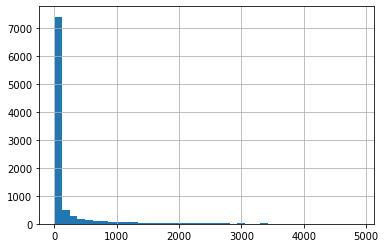

In [10]:
comments_responses.within_days.hist(bins=40)

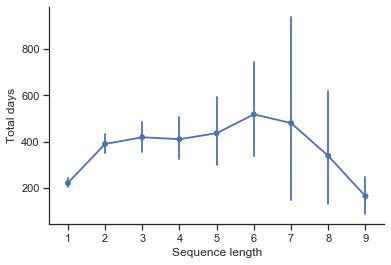

In [13]:
# plot total days between first and last turns by sequence length

summary = comments_responses.groupby('comment_id').timestamp.count().reset_index()
summary.columns = ['comment_id', 'length']

tmp = comments_responses.groupby('comment_id').within_days.sum().reset_index()
tmp.columns = ['comment_id', 'total_days']
summary = summary.merge(tmp, on='comment_id')


sns.set(style="ticks", rc={"lines.linewidth": 1})

g = sns.pointplot(x="length", y="total_days", data=summary)
plt.xlabel('Sequence length')
plt.ylabel('Total days')
remove_border(g)
# plt.savefig('../plots/totaldays_by_seqlen.pdf', bbox_inches='tight')

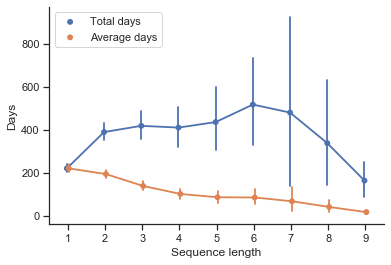

In [18]:
# add average days between turns by sequence length to the above plot

tmp = comments_responses.groupby('comment_id').within_days.mean().reset_index()
tmp.columns = ['comment_id', 'avg_days']
summary = summary.merge(tmp, on='comment_id')

reformatted = summary[['length', 'total_days']]
reformatted.columns = ['length', 'y']
reformatted['kind'] = 'Total days'

tmp = summary[['length', 'avg_days']]
tmp.columns = ['length', 'y']
reformatted = reformatted.append(tmp)
reformatted = reformatted.fillna('Average days')

g = sns.pointplot(x="length", y="y", hue='kind', dodge=True, data=reformatted)
g.legend(title=None)
plt.xlabel('Sequence length')
plt.ylabel('Days')
remove_border(g)

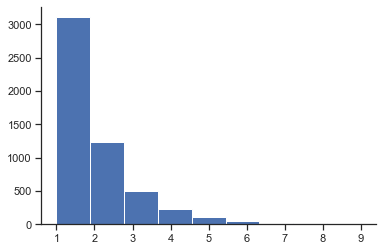

In [19]:
plt.hist(summary.length, bins=9)
remove_border()

In [20]:
summary.length.value_counts()

1    3106
2    1231
3     501
4     227
5     103
6      47
7      22
8      17
9      13
Name: length, dtype: int64

## Time gap by actions

In [25]:
comments_responses['interval'] = pd.cut(comments_responses.within_days, 
                                         [0, 1, 7, 30, 180, 365, comments_responses.within_days.max()])
comments_responses.head()

,comment_id,id,step,timestamp,toxic,type2,timegap,within_days,interval
0,100056213.25366.25366,100058183.25366.25366,0.0,2007-01-11 20:17:19+00:00,False,MODIFY,0 days 00:08:16,1,"(0, 1]"
1,100056213.25366.25366,100445924.25366.25366,1.0,2007-01-13 14:57:21+00:00,False,MODIFY,1 days 18:40:02,2,"(1, 7]"
2,100056213.25366.25366,148665933.514.30246,2.0,2007-08-02 06:41:28+00:00,False,ARCHIVE,200 days 15:44:07,201,"(180, 365]"
3,10011304.27024.26589,10966162.443.32875,0.0,2005-03-09 19:31:24+00:00,False,REMOVE,30 days 21:32:28,31,"(30, 180]"
4,10011440.16241.16241,10069406.16241.16241,0.0,2005-02-06 22:22:09+00:00,False,MODIFY,0 days 00:04:45,1,"(0, 1]"


In [28]:
pd.crosstab(comments_responses.interval, comments_responses.type2, 
            normalize=1, margins=True)

type2,ARCHIVE,MODIFY,REMOVE,REPLY,RESTORE,All
interval,,,,,,
"(0, 1]",0.033545,0.848921,0.565527,0.770792,0.721414,0.542524
"(1, 7]",0.058930,0.043765,0.081909,0.093069,0.045738,0.070021
"(7, 30]",0.150045,0.026379,0.086182,0.036634,0.064449,0.078624
"(30, 180]",0.328649,0.034772,0.136396,0.046040,0.124740,0.143635
"(180, 365]",0.111967,0.017386,0.051638,0.018317,0.012474,0.050528
"(365, 4884]",0.316863,0.028777,0.078348,0.035149,0.031185,0.114668


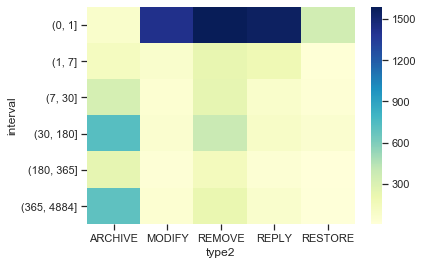

In [27]:
sns.heatmap(pd.crosstab(comments_responses.interval, comments_responses.type2), 
            cmap="YlGnBu")

In [230]:
pd.crosstab(alexa.interval2, alexa.type2, normalize=1, margins=True)

type2,ARCHIVE,MODIFY,REMOVE,REPLY,RESTORE,All
interval2,,,,,,
1,0.033545,0.848921,0.565527,0.770792,0.721414,0.542524
2,0.218948,0.070144,0.173077,0.130198,0.112266,0.152782
3,0.747507,0.080935,0.261396,0.099010,0.166320,0.304693


## Sequence permutation

### Reformat sequences

In [30]:
# insert an absorbing state 'LEAVE' at the end of each sequence if it doesn't have one

(full_responses.groupby('comment_id').last().type2 == 'LEAVE').value_counts()

False    4531
True     2207
Name: type2, dtype: int64

In [34]:
tmp = full_responses.groupby('comment_id').last().type2 == 'LEAVE'

leave_rows = pd.DataFrame(tmp.index[tmp==False])
leave_rows['type2'] = 'LEAVE'

# use data collection time
utc = full_responses.iloc[0]['timestamp'].tz
endtime = datetime(2018, 7, 1, 0, 0, tzinfo=utc)
leave_rows['timestamp'] = endtime
leave_rows.head()

,comment_id,type2,timestamp
0,100056213.25366.25366,LEAVE,2018-07-01 00:00:00+00:00
1,10011304.27024.26589,LEAVE,2018-07-01 00:00:00+00:00
2,10011440.16241.16241,LEAVE,2018-07-01 00:00:00+00:00
3,100161230.490.490,LEAVE,2018-07-01 00:00:00+00:00
4,100662878.64368.64368,LEAVE,2018-07-01 00:00:00+00:00


In [54]:
full_responses = full_responses.append(leave_rows)
full_responses = full_responses.sort_values(['comment_id', 'timestamp'])

In [56]:
# edit step column

def edit_df(df):
    df = df.reset_index(drop=True).reindex(np.arange(11))
    df.step = np.arange(11)
    df = df.reset_index(drop=True)
    df.step = df.index
    df.comment_id = df.iloc[0]['comment_id']
    return df

full_responses = full_responses.groupby('comment_id').apply(edit_df)
full_responses[['step']].head()

step
comment_id                   
100056213.25366.25366 0     0
                      1     1
                      2     2
                      3     3
                      4     4

In [57]:
# reformat sequences in long format
seq = full_responses.pivot(index='comment_id', columns='step', values='type2').reset_index(level='comment_id')
seq.head()

step,comment_id,0,1,2,3,4,5,6,7,8,9,10
0,100056213.25366.25366,MODIFY,MODIFY,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10011304.27024.26589,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10011440.16241.16241,MODIFY,MODIFY,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100161230.490.490,MODIFY,MODIFY,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100202560.123.74,MODIFY,MODIFY,MODIFY,MODIFY,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# check first row
full_responses[full_responses.comment_id=='100056213.25366.25366'].type2

comment_id               
100056213.25366.25366  0      MODIFY
                       1      MODIFY
                       2     ARCHIVE
                       3       LEAVE
                       4         NaN
                       5         NaN
                       6         NaN
                       7         NaN
                       8         NaN
                       9         NaN
                       10        NaN
Name: type2, dtype: object

In [60]:
# rename columns
new_cols = ['s%i'%col if col != 'comment_id' else col for col in seq.columns]
seq.columns = new_cols
seq

,comment_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,100056213.25366.25366,MODIFY,MODIFY,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10011304.27024.26589,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10011440.16241.16241,MODIFY,MODIFY,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100161230.490.490,MODIFY,MODIFY,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100202560.123.74,MODIFY,MODIFY,MODIFY,MODIFY,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6733,99557021.9923.9923,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6734,99595754.29060.29024,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6735,9960764.1654.1654,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6736,99689928.16863.16863,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
seq['seq_str'] = seq.apply(lambda row: '-'.join([row['s%i'%i] for i in range(11) if pd.notnull(row['s%i'%i])]), axis=1)
seq.head()

,comment_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,seq_str
0,100056213.25366.25366,MODIFY,MODIFY,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODIFY-MODIFY-ARCHIVE-LEAVE
1,10011304.27024.26589,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REMOVE-LEAVE
2,10011440.16241.16241,MODIFY,MODIFY,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODIFY-MODIFY-REMOVE-LEAVE
3,100161230.490.490,MODIFY,MODIFY,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODIFY-MODIFY-REMOVE-LEAVE
4,100202560.123.74,MODIFY,MODIFY,MODIFY,MODIFY,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,MODIFY-MODIFY-MODIFY-MODIFY-LEAVE


### Sequence counts

In [65]:
# sequences of length 1
seq[seq.s1.isnull()].seq_str.value_counts()

LEAVE    1471
Name: seq_str, dtype: int64

In [69]:
# sequences of length 2
seq[((seq.s2.isnull() & (seq.s1.notnull())))].seq_str.value_counts()

REMOVE-LEAVE     1792
ARCHIVE-LEAVE     852
REPLY-LEAVE       250
MODIFY-LEAVE      206
Name: seq_str, dtype: int64

In [70]:
# sequences of length 3
seq[((seq.s3.isnull() & (seq.s2.notnull())))].seq_str.value_counts()

REPLY-ARCHIVE-LEAVE      456
MODIFY-ARCHIVE-LEAVE     292
MODIFY-REMOVE-LEAVE      165
REPLY-REMOVE-LEAVE       132
REPLY-REPLY-LEAVE         68
MODIFY-MODIFY-LEAVE       64
REMOVE-RESTORE-LEAVE      28
REPLY-MODIFY-LEAVE         9
ARCHIVE-ARCHIVE-LEAVE      3
ARCHIVE-RESTORE-LEAVE      2
MODIFY-REPLY-LEAVE         1
REMOVE-REMOVE-LEAVE        1
Name: seq_str, dtype: int64

### Transition probability matrix for sequences of lengths >= 3

In [74]:
states = full_responses.type2.unique().tolist()
states = [s for s in states if pd.notnull(s)]
states.sort()
states

['ARCHIVE', 'LEAVE', 'MODIFY', 'REMOVE', 'REPLY', 'RESTORE']

In [84]:
# manually order states
states = ['REPLY', 'MODIFY', 'RESTORE', 'ARCHIVE', 'REMOVE', 'LEAVE']

In [79]:
# pairs of consecutive actions
seq[seq.s2.notnull()].apply(lambda row: [(row['s%i'%i], row['s%i'%(i+1)]) 
                                         for i in range(10) if pd.notnull(row['s%i'%(i+1)])], axis=1)

0       [(MODIFY, MODIFY), (MODIFY, ARCHIVE), (ARCHIVE...
2       [(MODIFY, MODIFY), (MODIFY, REMOVE), (REMOVE, ...
3       [(MODIFY, MODIFY), (MODIFY, REMOVE), (REMOVE, ...
4       [(MODIFY, MODIFY), (MODIFY, MODIFY), (MODIFY, ...
7                    [(REPLY, ARCHIVE), (ARCHIVE, LEAVE)]
                              ...                        
6719    [(REMOVE, RESTORE), (RESTORE, ARCHIVE), (ARCHI...
6724                  [(MODIFY, REMOVE), (REMOVE, LEAVE)]
6728                [(MODIFY, ARCHIVE), (ARCHIVE, LEAVE)]
6729    [(MODIFY, MODIFY), (MODIFY, REMOVE), (REMOVE, ...
6731    [(REMOVE, RESTORE), (RESTORE, ARCHIVE), (ARCHI...
Length: 2167, dtype: object

In [80]:
counts = defaultdict(int)

for i, row in seq[seq.s2.notnull()].iterrows():
    for i in range(10):
        if pd.notnull(row['s%i'%(i+1)]):
            counts[(row['s%i'%i], row['s%i'%(i+1)])] += 1

In [81]:
counts

defaultdict(int,
            {('MODIFY', 'MODIFY'): 545,
             ('MODIFY', 'ARCHIVE'): 488,
             ('ARCHIVE', 'LEAVE'): 1319,
             ('MODIFY', 'REMOVE'): 314,
             ('REMOVE', 'LEAVE'): 568,
             ('MODIFY', 'LEAVE'): 119,
             ('REPLY', 'ARCHIVE'): 674,
             ('REMOVE', 'RESTORE'): 430,
             ('RESTORE', 'REMOVE'): 230,
             ('REPLY', 'REPLY'): 646,
             ('REPLY', 'REMOVE'): 268,
             ('REPLY', 'MODIFY'): 70,
             ('RESTORE', 'MODIFY'): 18,
             ('RESTORE', 'ARCHIVE'): 171,
             ('RESTORE', 'LEAVE'): 48,
             ('REMOVE', 'REMOVE'): 14,
             ('REPLY', 'LEAVE'): 113,
             ('ARCHIVE', 'ARCHIVE'): 44,
             ('ARCHIVE', 'RESTORE'): 34,
             ('REMOVE', 'REPLY'): 14,
             ('REPLY', 'RESTORE'): 15,
             ('REMOVE', 'ARCHIVE'): 2,
             ('RESTORE', 'REPLY'): 13,
             ('RESTORE', 'RESTORE'): 5,
             ('MODIFY', 'REPLY'

In [98]:
# make a matrix

count_matrix = pd.DataFrame(columns=states, index=states)
count_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,NaN,NaN,NaN,NaN,NaN,NaN
MODIFY,NaN,NaN,NaN,NaN,NaN,NaN
RESTORE,NaN,NaN,NaN,NaN,NaN,NaN
ARCHIVE,NaN,NaN,NaN,NaN,NaN,NaN
REMOVE,NaN,NaN,NaN,NaN,NaN,NaN
LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
for k, v in counts.items():
    count_matrix.loc[k[0], k[1]] = v
    
count_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,646,70,15,674,268,113
MODIFY,2,545,NaN,488,314,119
RESTORE,13,18,5,171,230,48
ARCHIVE,1,NaN,34,44,NaN,1319
REMOVE,14,2,430,2,14,568
LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
count_matrix = count_matrix.fillna(0)

In [104]:
# row sums to 1
prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
prob_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,0.361702,0.039194,0.008399,0.377380,0.150056,0.063270
MODIFY,0.001362,0.371253,0.000000,0.332425,0.213896,0.081063
RESTORE,0.026804,0.037113,0.010309,0.352577,0.474227,0.098969
ARCHIVE,0.000715,0.000000,0.024320,0.031474,0.000000,0.943491
REMOVE,0.013592,0.001942,0.417476,0.001942,0.013592,0.551456
LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# columns may not sum to 1
prob_matrix.sum(axis=0)

REPLY      0.404176
MODIFY     0.449502
RESTORE    0.460504
ARCHIVE    1.095797
REMOVE     0.851771
LEAVE      2.738249
dtype: float64

In [106]:
prob_matrix = prob_matrix.fillna(0)
prob_matrix.loc['LEAVE', 'LEAVE'] = 1
prob_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,0.361702,0.039194,0.008399,0.377380,0.150056,0.063270
MODIFY,0.001362,0.371253,0.000000,0.332425,0.213896,0.081063
RESTORE,0.026804,0.037113,0.010309,0.352577,0.474227,0.098969
ARCHIVE,0.000715,0.000000,0.024320,0.031474,0.000000,0.943491
REMOVE,0.013592,0.001942,0.417476,0.001942,0.013592,0.551456
LEAVE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


<font size=3>REMOVE and ARCHIVE should have 0 on the diagonal.</font>

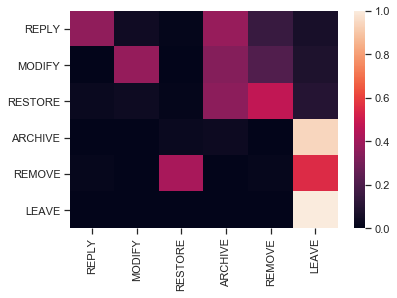

In [107]:
sns.heatmap(prob_matrix)

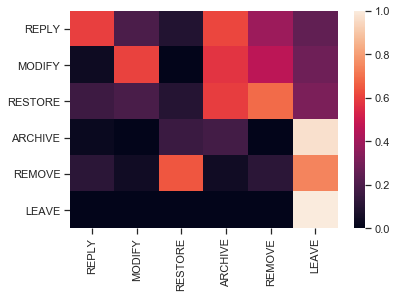

In [108]:
# take square root to see more variations
sns.heatmap(np.sqrt(prob_matrix))